<a href="https://colab.research.google.com/github/sjamillah/Linear_Regression_Model/blob/main/Feel_Heal_linear_regression_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importations

In [ ]:
import pandas as pd
import numpy as np
import pickle
import datetime
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Dataset Processing

In [ ]:
print("\nReading dataset......")
file_path = "/content/drive/MyDrive/Colab Notebooks/Data/Health_Sleep_Statistics.csv"
data = pd.read_csv(file_path)
print("Dataset read successfully!")

print("-" * 50)
print(f"Initial Shape: {data.shape}")
print("-" * 50)
print(f"Columns: {data.columns}")

# dropping some columns
columns_to_drop = ['User ID', 'Gender', 'Dietary Habits', 'Sleep Disorders']
data = data.drop(columns=columns_to_drop)
print(f"\nDropped {len(columns_to_drop)} unnecessary columns")

# Convert categorical to numeric
medication_label_encoder = LabelEncoder()
physical_label_encoder = LabelEncoder()
data['Physical Activity Level'] = physical_label_encoder.fit_transform(data['Physical Activity Level'].str.lower())
data['Medication Usage'] = medication_label_encoder.fit_transform(data['Medication Usage'].str.lower())

# Add synthetic columns
np.random.seed(42)
num_rows = len(data)
data['Heart Rate'] = np.random.randint(60, 100, num_rows)
data['Social Interaction'] = np.random.randint(0, 5, num_rows)

# Process time columns
data['Bedtime'] = pd.to_datetime('2024-01-01 ' + data['Bedtime'])
data['Wake-up Time'] = pd.to_datetime('2024-01-01 ' + data['Wake-up Time'])
data['Sleep Duration'] = (data['Wake-up Time'] - data['Bedtime']).dt.total_seconds() / 3600
data.loc[data['Sleep Duration'] < 0, 'Sleep Duration'] += 24

# Handle missing values
numeric_data = data.select_dtypes(include=[np.number])
data[numeric_data.columns] = numeric_data.fillna(numeric_data.median())

# Validate data ranges
print("\nValidating data ranges...")

# Validate Social Interaction (0-5)
invalid_social = ~data['Social Interaction'].between(0, 5)
print(f"Invalid Social Interaction values: {sum(invalid_social)}")
data.loc[invalid_social, 'Social Interaction'] = data['Social Interaction'].clip(0, 5)

# Validate Sleep Quality (1-10)
data['Sleep Quality'] = data['Sleep Quality'].clip(1, 10)

# Validate Daily Steps (max 11000)
data['Daily Steps'] = data['Daily Steps'].clip(0, 11000)

# Validate Calories Burned (max 2900)
data['Calories Burned'] = data['Calories Burned'].clip(0, 2900)

print("\nPreprocessing complete.")
print("-" * 50)
print(f"Final Shape: {data.shape}")
print("-" * 50)
print(data.head())


Reading dataset......
Dataset read successfully!
--------------------------------------------------
Initial Shape: (100, 12)
--------------------------------------------------
Columns: Index(['User ID', 'Age', 'Gender', 'Sleep Quality', 'Bedtime', 'Wake-up Time',
       'Daily Steps', 'Calories Burned', 'Physical Activity Level',
       'Dietary Habits', 'Sleep Disorders', 'Medication Usage'],
      dtype='object')

Dropped 4 unnecessary columns

Validating data ranges...
Invalid Social Interaction values: 0

Preprocessing complete.
--------------------------------------------------
Final Shape: (100, 11)
--------------------------------------------------
   Age  Sleep Quality             Bedtime        Wake-up Time  Daily Steps  \
0   25              8 2024-01-01 23:00:00 2024-01-01 06:30:00         8000   
1   34              7 2024-01-01 00:30:00 2024-01-01 07:00:00         5000   
2   29              9 2024-01-01 22:45:00 2024-01-01 06:45:00         9000   
3   41              5 2

Standardization

In [ ]:
# Standardize numeric columns
standardize_columns = ['Sleep Quality', 'Daily Steps', 'Calories Burned', 'Heart Rate', 'Sleep Duration']
scaler = StandardScaler()
data[standardize_columns] = scaler.fit_transform(data[standardize_columns])

print("\nStandardization complete.")
print("-" * 50)
print(data.head())

np.random.seed(42)

# Normalize components for better scoring
sleep_norm = (data['Sleep Quality'] - data['Sleep Quality'].min()) / (data['Sleep Quality'].max() - data['Sleep Quality'].min())
activity_norm = (data['Physical Activity Level'] - data['Physical Activity Level'].min()) / (data['Physical Activity Level'].max() - data['Physical Activity Level'].min())
social_norm = (data['Social Interaction'] - data['Social Interaction'].min()) / (data['Social Interaction'].max() - data['Social Interaction'].min())
heart_norm = (data['Heart Rate'] - data['Heart Rate'].min()) / (data['Heart Rate'].max() - data['Heart Rate'].min())

# Calculate Anxiety Level
data['Anxiety_Level'] = np.clip(
    (1 - sleep_norm) * 0.3 +
    (1 - activity_norm) * 0.2 +
    (1 - social_norm / 4) * 0.25 +
    heart_norm * 0.15 +
    np.random.normal(0, 0.05, len(data)),
    0, 1
)

# Calculate Depression Level
data['Depression_Level'] = np.clip(
    (1 - sleep_norm) * 0.3 +
    (1 - activity_norm) * 0.2 +
    (1 - social_norm / 4) * 0.25 +
    (1 - heart_norm) * 0.15 +
    np.random.normal(0, 0.05, len(data)),
    0, 1
)

print("Mean of Standardized Columns:")
print(data[standardize_columns].mean())
print("Standard Deviation of Standardized Columns:")
print(data[standardize_columns].std())
# Check proportion of clipped values
print("Clipped Anxiety Level:\n", (data['Anxiety_Level'] == 0).sum(), "values at 0,", (data['Anxiety_Level'] == 1).sum(), "values at 1")
print("Clipped Depression Level:\n", (data['Depression_Level'] == 0).sum(), "values at 0,", (data['Depression_Level'] == 1).sum(), "values at 1")



Standardization complete.
--------------------------------------------------
   Age  Sleep Quality             Bedtime        Wake-up Time  Daily Steps  \
0   25       0.579284 2024-01-01 23:00:00 2024-01-01 06:30:00     0.470601   
1   34       0.000000 2024-01-01 00:30:00 2024-01-01 07:00:00    -0.736068   
2   29       1.158569 2024-01-01 22:45:00 2024-01-01 06:45:00     0.872824   
3   41      -1.158569 2024-01-01 01:00:00 2024-01-01 06:30:00    -1.138292   
4   22       0.579284 2024-01-01 23:30:00 2024-01-01 07:00:00     1.275048   

   Calories Burned  Physical Activity Level  Medication Usage  Heart Rate  \
0         0.282487                        2                 0    1.670713   
1        -0.790249                        1                 1    0.801003   
2         0.997645                        0                 0   -0.416591   
3        -1.147828                        1                 0   -1.025388   
4         1.355223                        0                 0    0.1

Data Visualizations and Correlation

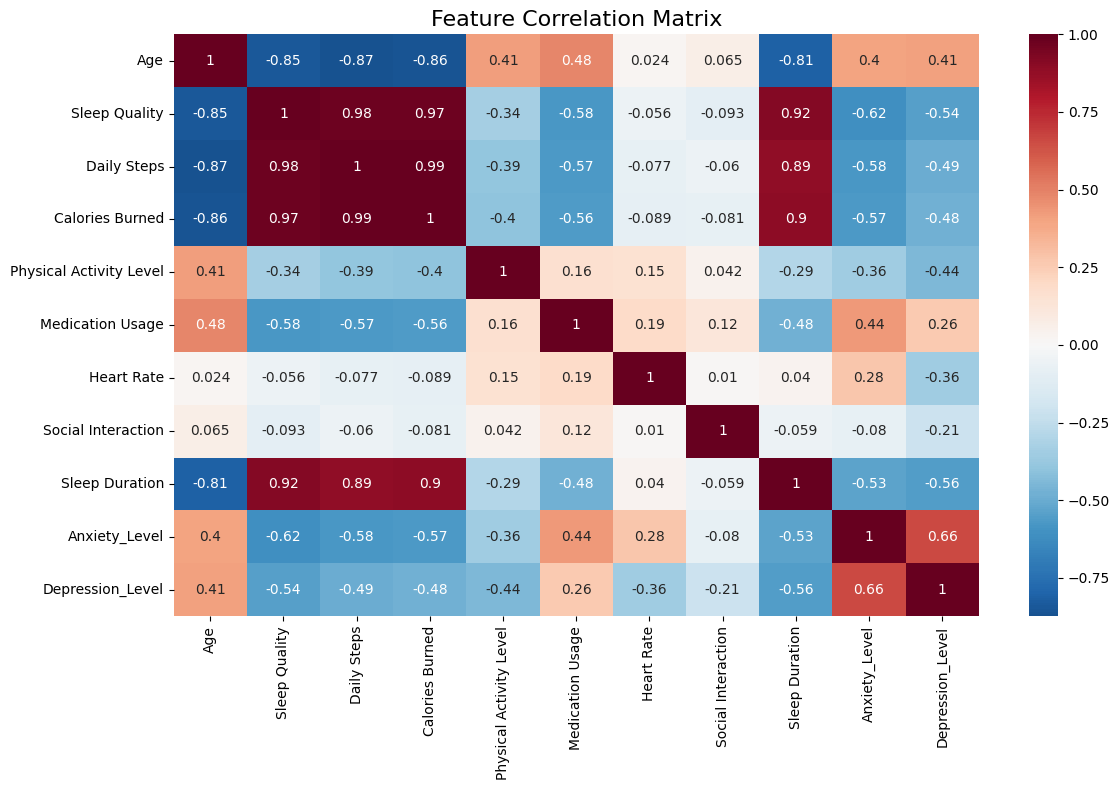

In [ ]:
# Correlation Matrix
plt.figure(figsize=(12, 8))
numeric_cols = data.select_dtypes(include=[np.number]).columns
sns.heatmap(data[numeric_cols].corr(), annot=True, cmap='RdBu_r', center=0)
plt.title('Feature Correlation Matrix', fontsize=16)
plt.tight_layout()
plt.show()


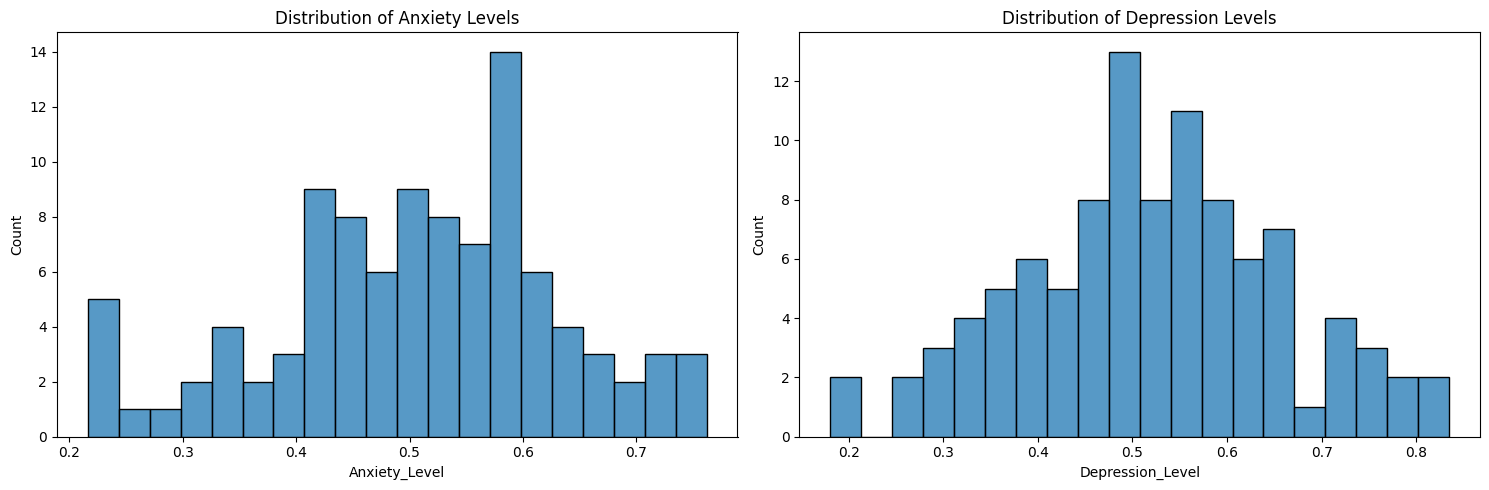

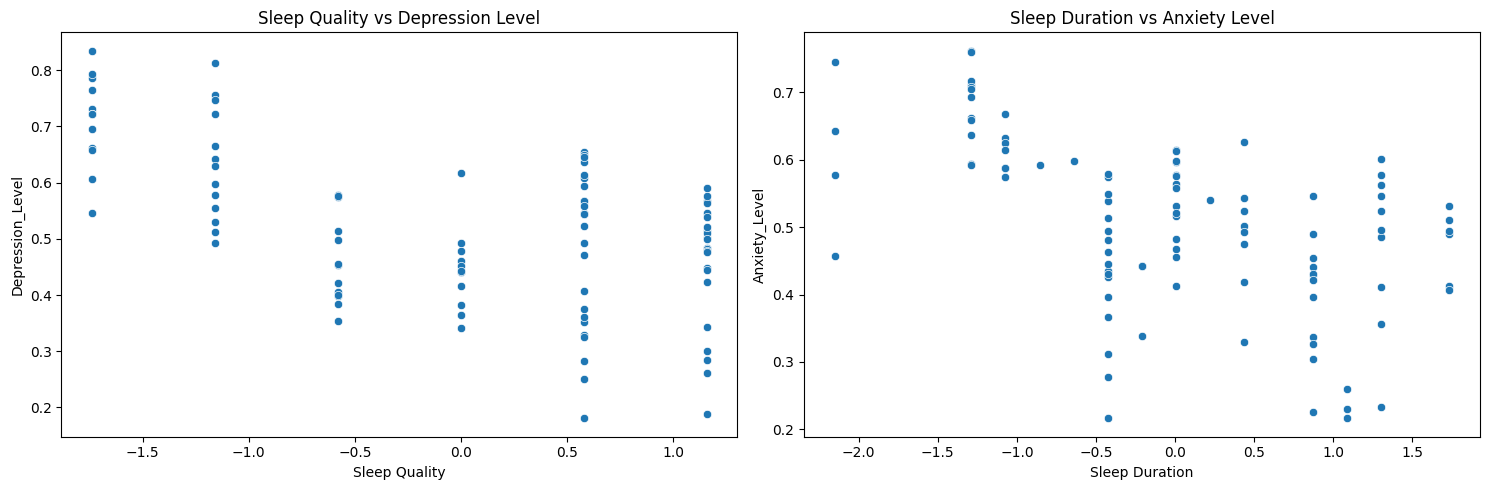

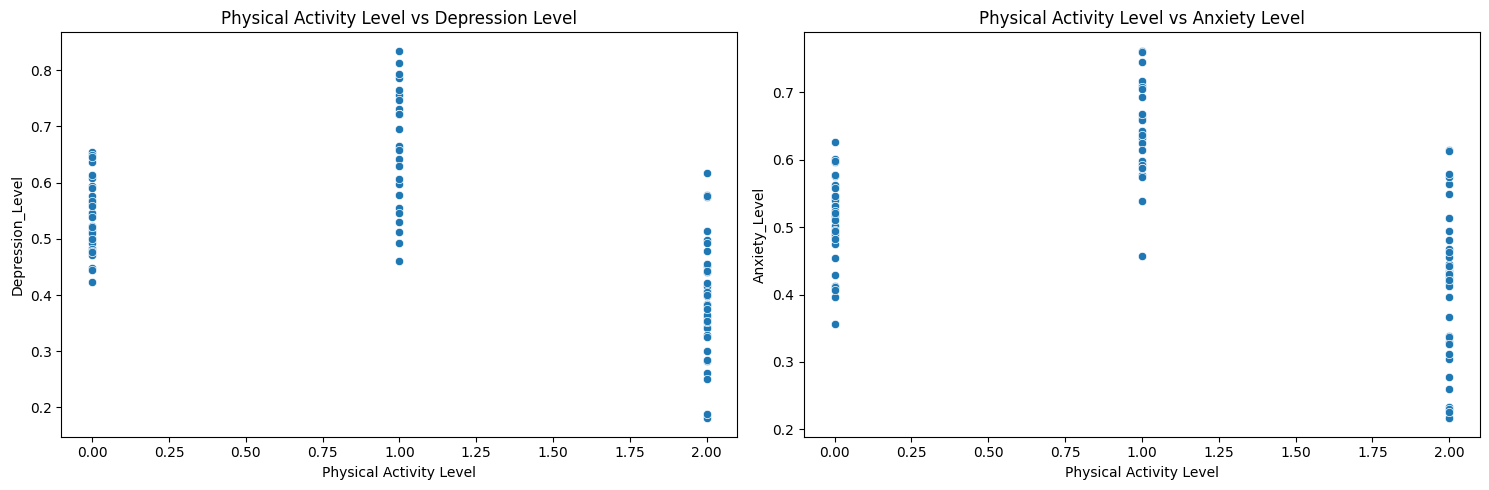

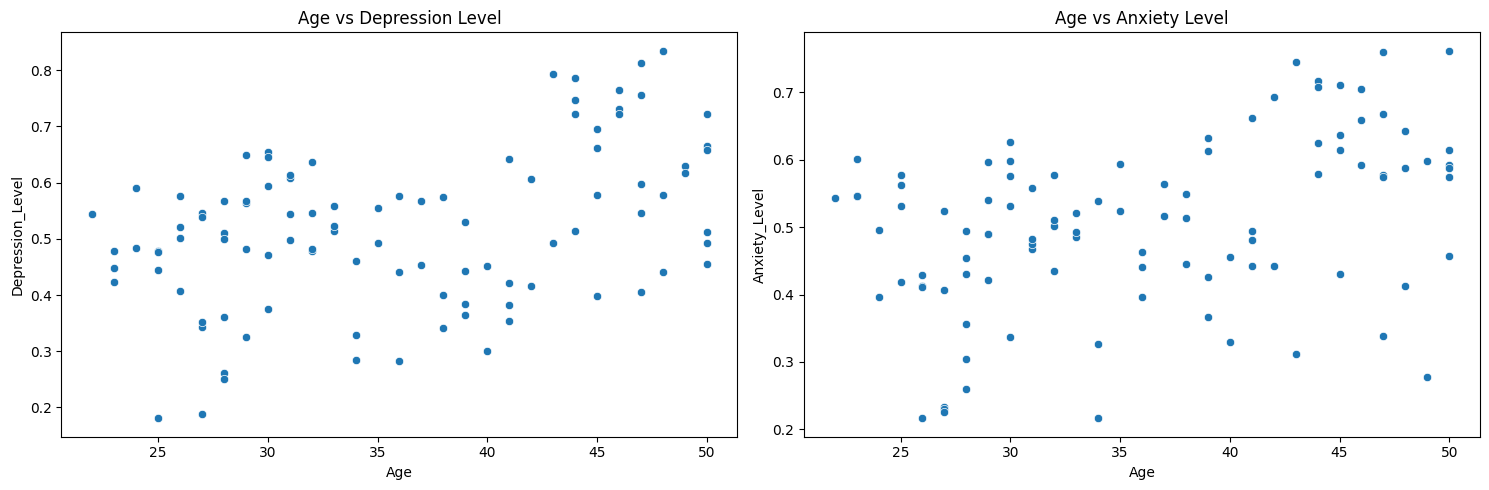

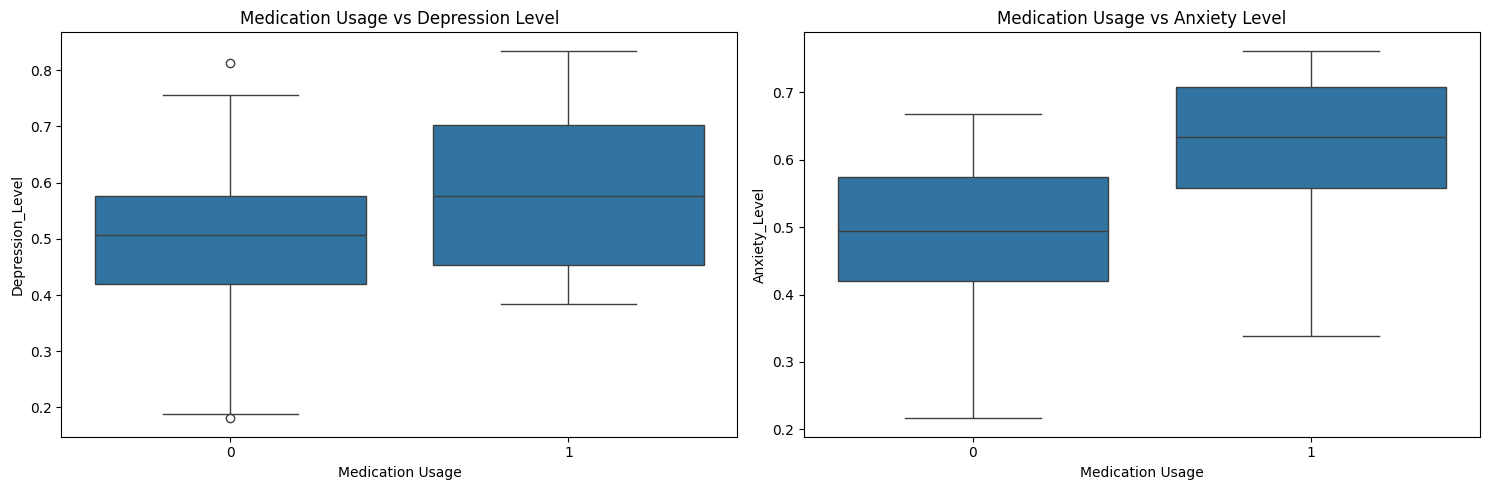

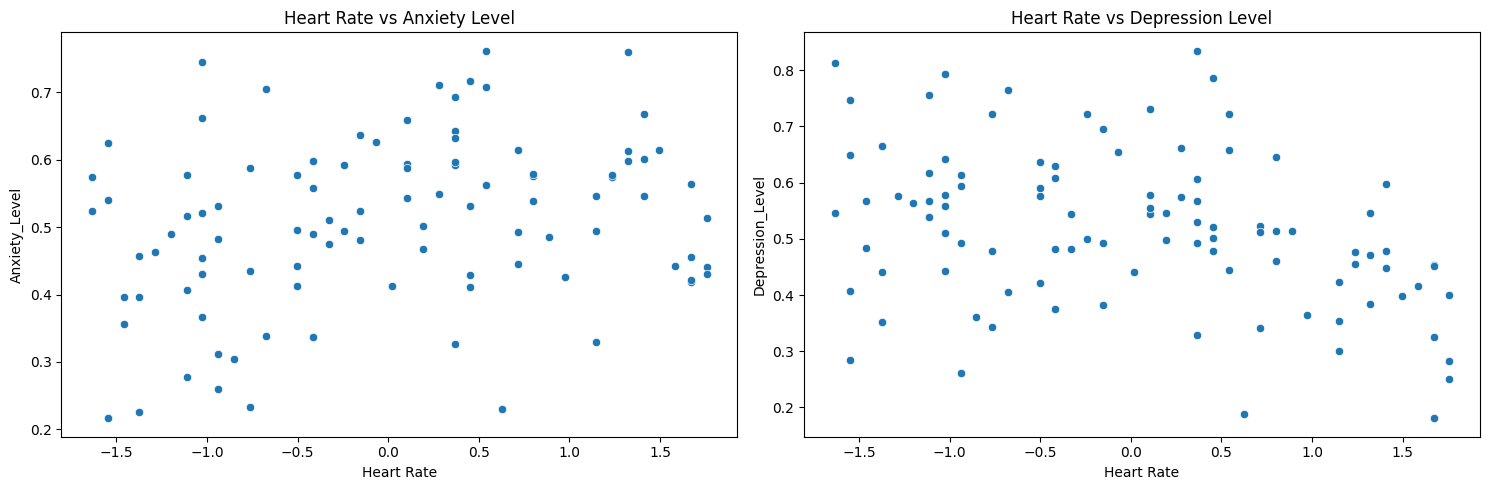

In [ ]:
# Distribution of Mental Health Metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data['Anxiety_Level'], ax=ax1, bins=20)
ax1.set_title('Distribution of Anxiety Levels')
sns.histplot(data['Depression_Level'], ax=ax2, bins=20)
ax2.set_title('Distribution of Depression Levels')
plt.tight_layout()
plt.show()

# Sleep Quality Relationships
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(data=data, x='Sleep Quality', y='Depression_Level', ax=axes[0])
axes[0].set_title('Sleep Quality vs Depression Level')
sns.scatterplot(data=data, x='Sleep Duration', y='Anxiety_Level', ax=axes[1])
axes[1].set_title('Sleep Duration vs Anxiety Level')
plt.tight_layout()
plt.show()

# Physical Activity Level
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(data=data, x='Physical Activity Level', y='Depression_Level', ax=axes[0])
axes[0].set_title('Physical Activity Level vs Depression Level')
sns.scatterplot(data=data, x='Physical Activity Level', y='Anxiety_Level', ax=axes[1])
axes[1].set_title('Physical Activity Level vs Anxiety Level')
plt.tight_layout()
plt.show()

# Age and Mental Health Relationships
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(data=data, x='Age', y='Depression_Level', ax=axes[0])
axes[0].set_title('Age vs Depression Level')
sns.scatterplot(data=data, x='Age', y='Anxiety_Level', ax=axes[1])
axes[1].set_title('Age vs Anxiety Level')
plt.tight_layout()
plt.show()

# Medication Usage
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(data=data, x='Medication Usage', y='Depression_Level', ax=axes[0])
axes[0].set_title('Medication Usage vs Depression Level')
sns.boxplot(data=data, x='Medication Usage', y='Anxiety_Level', ax=axes[1])
axes[1].set_title('Medication Usage vs Anxiety Level')
plt.tight_layout()
plt.show()

# Heart Rate Relationships
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(data=data, x='Heart Rate', y='Anxiety_Level', ax=axes[0])
axes[0].set_title('Heart Rate vs Anxiety Level')
sns.scatterplot(data=data, x='Heart Rate', y='Depression_Level', ax=axes[1])
axes[1].set_title('Heart Rate vs Depression Level')
plt.tight_layout()
plt.show()

Training and Testing

In [ ]:
features = ['Age', 'Sleep Quality', 'Daily Steps', 'Calories Burned', 'Heart Rate', 'Sleep Duration',
            'Physical Activity Level', 'Medication Usage', 'Social Interaction']
target = ['Anxiety_Level', 'Depression_Level']

In [ ]:
X = data[features]
y = data[target]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((80, 9), (20, 9), (80, 2), (20, 2))

Linear Regression

In [ ]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

In [ ]:
y_predict = linear_model.predict(X_test)
y_predict

array([[0.45300817, 0.56758974],
       [0.60586185, 0.76158088],
       [0.47944423, 0.53724576],
       [0.60483313, 0.7532156 ],
       [0.56846095, 0.4967504 ],
       [0.44372539, 0.47351883],
       [0.2634875 , 0.21472343],
       [0.4935276 , 0.57644196],
       [0.59868467, 0.58822206],
       [0.40217161, 0.22511538],
       [0.49609015, 0.45806681],
       [0.41258173, 0.55537958],
       [0.67123349, 0.639878  ],
       [0.7170924 , 0.73280038],
       [0.54763376, 0.44456953],
       [0.54236383, 0.54886268],
       [0.32701682, 0.35863737],
       [0.59472655, 0.76588461],
       [0.42396723, 0.273958  ],
       [0.49957979, 0.38550849]])

In [ ]:
y_predict_1d = y_predict[:, 0]
y_test_1d = y_test.iloc[:, 0].values
dataframe = pd.DataFrame({'Y_actual': y_test_1d, 'Y_predicted': y_predict_1d})
dataframe

,Y_actual,Y_predicted
0,0.431010,0.453008
1,0.624430,0.605862
2,0.510137,0.479444
3,0.577085,0.604833
4,0.493045,0.568461
5,0.442968,0.443725
6,0.329578,0.263487
7,0.482911,0.493528
8,0.592791,0.598685
9,0.418490,0.402172


Visualization showing the actual values vs the predicted values

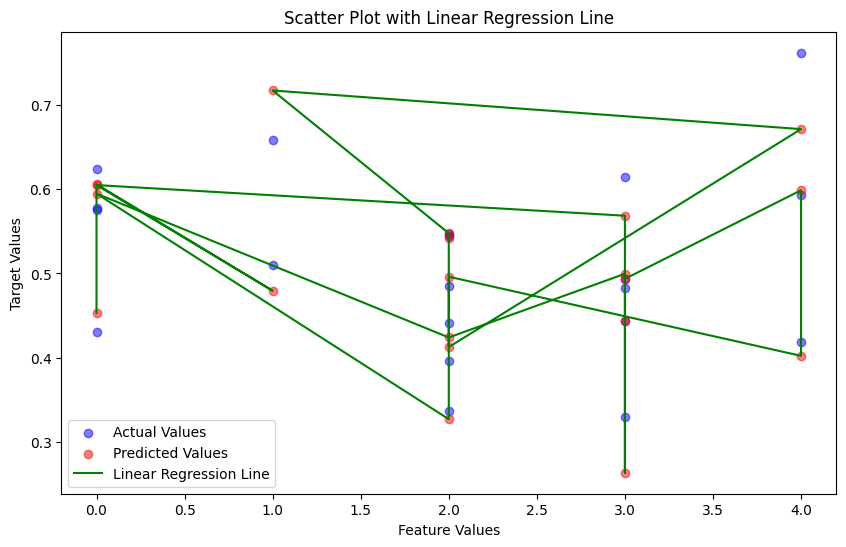

In [ ]:
# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(X_test['Social Interaction'], y_test_1d, color='blue', label='Actual Values', alpha=0.5)
plt.scatter(X_test['Social Interaction'], y_predict_1d, color='red', label='Predicted Values', alpha=0.5)

# Plot the linear regression line
plt.plot(X_test['Social Interaction'], y_predict_1d, color='green', label='Linear Regression Line')

# Add labels, legend, and title
plt.xlabel("Feature Values")
plt.ylabel("Target Values")
plt.title("Scatter Plot with Linear Regression Line")
plt.legend()

# Display the plot
plt.show()


Error calculation

In [ ]:
r2_score(y_test_1d, y_predict_1d)
print(f"R2 Score: {round(r2_score(y_test_1d, y_predict_1d), 4) * 100} %")

R2 Score: 82.93 %


In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test_1d, y_predict_1d)
print(f"Mean Absolute Error: {(mean_absolute_error(y_test_1d, y_predict_1d))}")

Mean Absolute Error: 0.03072628585731187


In [ ]:
mean_squared_error(y_test_1d, y_predict_1d)
print(f"Mean Squared Error: {mean_squared_error(y_test_1d, y_predict_1d)}")

Mean Squared Error: 0.0019486356983286386


In [ ]:
rmse = np.sqrt(mean_squared_error(y_test_1d, y_predict_1d))
print(f"Root Mean Squared Error: {rmse}")


Root Mean Squared Error: 0.04414335395423232


Model comparison and ranking from the best to the worst

In [ ]:
# Train Decision Tree
decision_tree_model = DecisionTreeRegressor(
    max_depth=5,  # Prevent overfitting
    min_samples_split=10,
    random_state=42
)
decision_tree_model.fit(X_train, y_train)
y_predict_decision_tree = decision_tree_model.predict(X_test)

# Train Random Forest
random_forest_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=5,  # Prevent overfitting
    min_samples_split=10,
    random_state=42
)
random_forest_model.fit(X_train, y_train)
y_predict_random_forest = random_forest_model.predict(X_test)

# Calculate RMSE for all models
rmse_decision_tree = np.sqrt(mean_squared_error(y_test, y_predict_decision_tree))
rmse_random_forest = np.sqrt(mean_squared_error(y_test, y_predict_random_forest))

rank_models = {
    'Linear Regression': rmse,
    'Decision Tree': rmse_decision_tree,
    'Random Forest': rmse_random_forest
}

sort_the_model = sorted(rank_models.items(), key=lambda x: x[1])

print("RMSE Scores(Highest to Lowest):")
for model, rmse_score in sort_the_model:
    print(f"{model}: {rmse_score:.2f}")



RMSE Scores(Highest to Lowest):
Linear Regression: 0.04
Random Forest: 0.06
Decision Tree: 0.07


Saving the model

In [ ]:
save_model = {
    'model': linear_model,
    'label_encoders': {
        'Physical Activity Level': physical_label_encoder,
        'Medication Usage': medication_label_encoder
        },
    'features': features
}
with open('mental_health_model2.pkl', 'wb') as file:
    pickle.dump(save_model, file)

In [ ]:
try:
    with open('mental_health_model2.pkl', 'rb') as file:
        saved_model = pickle.load(file)

    model = saved_model['model']
    label_encoders = saved_model['label_encoders']
    features = saved_model['features']

    print("Model, label encoders, and features loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")

Model, label encoders, and features loaded successfully.


In [ ]:
print(type(model))  # Should output the type of the model, e.g., sklearn model


<class 'sklearn.linear_model._base.LinearRegression'>
